## Introduzione
Caricamento dataset e modifiche iniziali

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("drive/MyDrive/smoking.csv", sep=",")

In [ ]:
df.head()

Si è deciso di ridurre la dimensione del dataset da oltre 50.000 a 10.000 valori al fine di ottimizzare i tempi di addestramento dei modelli, garantendo così una maggiore efficienza nel processo di analisi e sviluppo. È importante sottolineare che nonostante questa riduzione, il rapporto tra i valori delle due classi della colonna target rimane invariato, mantenendo l'integrità e la rappresentatività dei dati.

In [4]:
original_counts = df['smoking'].value_counts()
print("Counts nel dataset originale:\n", original_counts)
print("Rapporto:\n", original_counts[0]/original_counts[1])

df = df[:10000]

sampled_counts = df['smoking'].value_counts()
print("\nCounts nel dataset partizionato:\n", sampled_counts)
print("Rapporto:\n", sampled_counts[0]/sampled_counts[1])

Counts nel dataset originale:
 0    35237
1    20455
Name: smoking, dtype: int64
Rapporto:
 1.7226594964556343

Counts nel dataset partizionato:
 0    6384
1    3616
Name: smoking, dtype: int64
Rapporto:
 1.7654867256637168


Innanzitutto eliminiamo la colonna "ID" in quanto non è indicativa per il nostro target: "smoking"

In [ ]:
df = df.drop(['ID'], axis=1)

In [ ]:
df.dtypes

Per semplificare il processo di analisi e trattamento dei dati, abbiamo convertito le colonne che originariamente contenevano solo valori "M/F" o "Y/N" in un formato binario utilizzando la codifica 0/1. Questa trasformazione consente una maggiore uniformità e facilità di manipolazione dei dati durante le fasi di elaborazione e modellazione. Anziché gestire valori testuali come "M" o "F", ora possiamo utilizzare valori numerici come 1 per "M" e 0 per "F", e 1 per "Y" e 0 per "N".

In [5]:
df['tartar'] = df['tartar'].apply(lambda x: 1 if x == 'Y' else 0)
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)
df['oral'] = df['oral'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
df.dtypes

## Analisi covariate

In [ ]:
import numpy as np
# Crea un istogramma e un boxplot per ogni colonna del dataset
for col in df.columns:
    # Istogramma
    plt.figure(figsize=(8, 6))
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Istogramma di {col}')
    plt.xlabel(col)
    plt.ylabel('Frequenza')
    plt.show()

    x_values = np.random.uniform(0.5, 1.5, size=len(df[col]))

    plt.figure(figsize=(8, 6), facecolor='white')

    # Boxplot (sovrapposto a scatter plot)
    plt.boxplot(df[col], widths=1.5, patch_artist=True,  boxprops=dict(edgecolor=(1.0, 0.0, 1.0), facecolor='none', linewidth=2.5), medianprops=dict(color='red', linewidth=2.5))

    # Scatter plot
    plt.scatter(x_values, df[col], s=10, color='black', alpha=0.5)

    plt.title(f'Boxplot e scatter plot di {col}')
    plt.ylabel(col)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Dai grafici e anche dalla colonna che segue possiamo vedere che la colonna "oral" contiene solo una classe, perciò proseguiamo eliminandola poichè non è indicativa per il nostro target

In [ ]:
print(df['oral'].unique())

In [6]:
df = df.drop(['oral'], axis=1)

In [ ]:
attributi_discreti = ['gender', 'hearing(left)', 'hearing(right)', 'dental caries', 'tartar']

attributi_continui = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp']

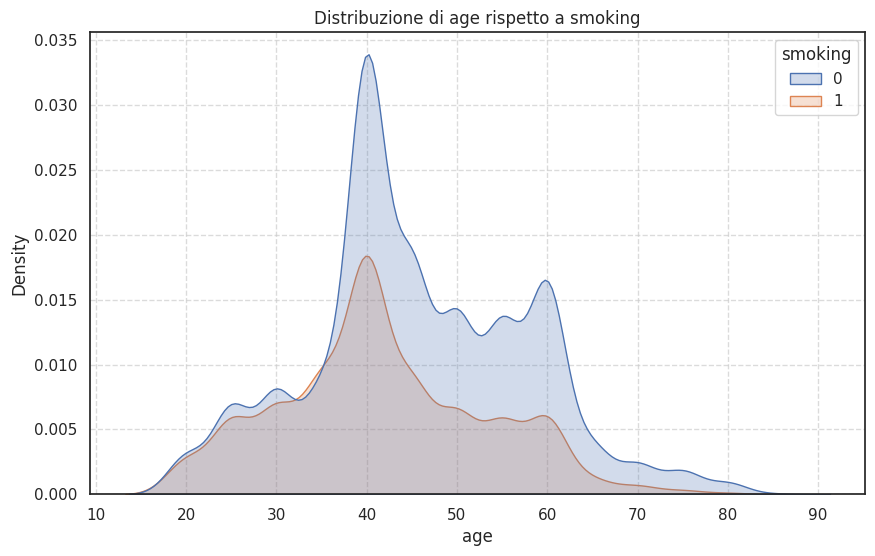

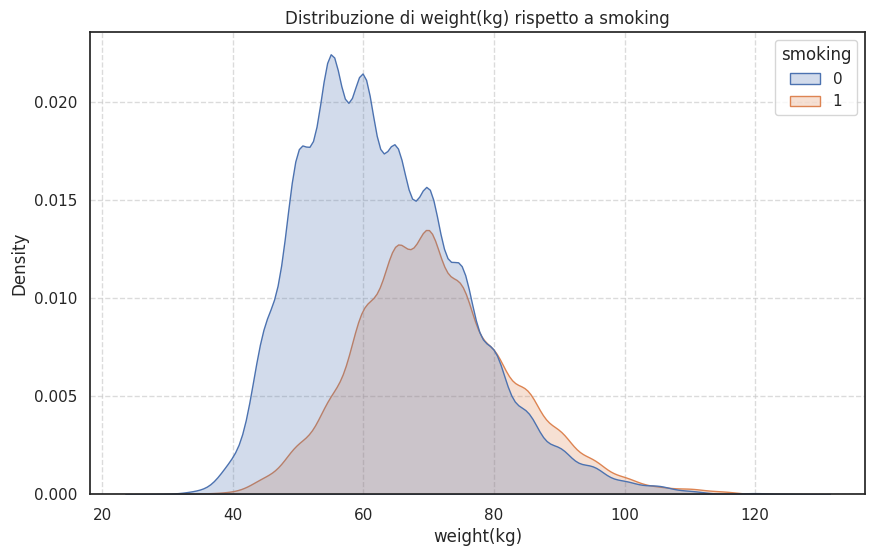

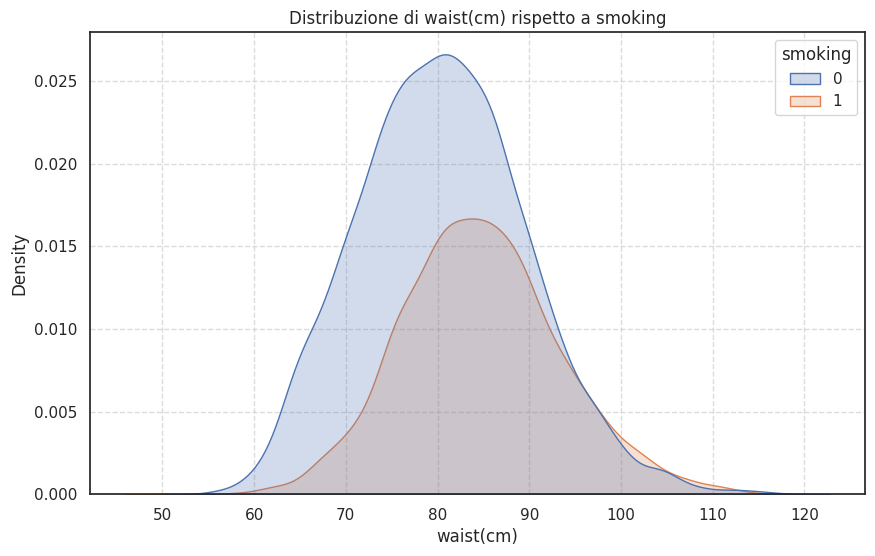

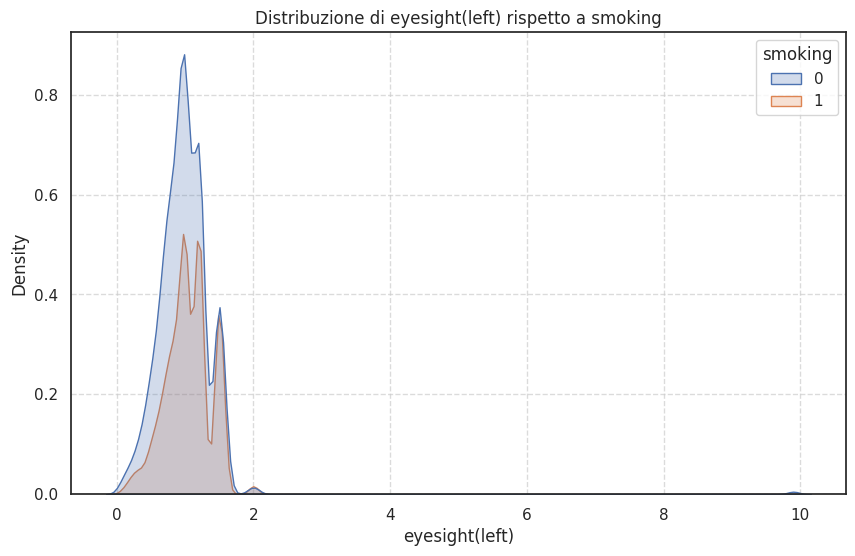

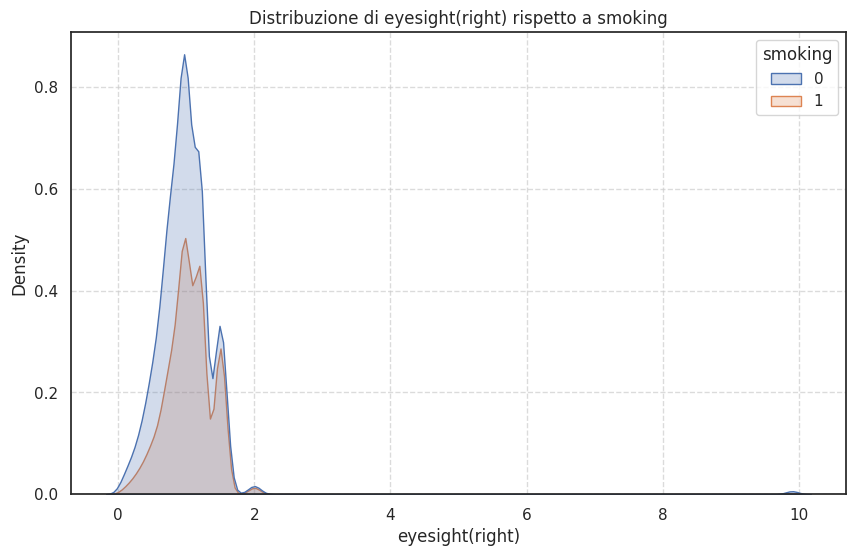

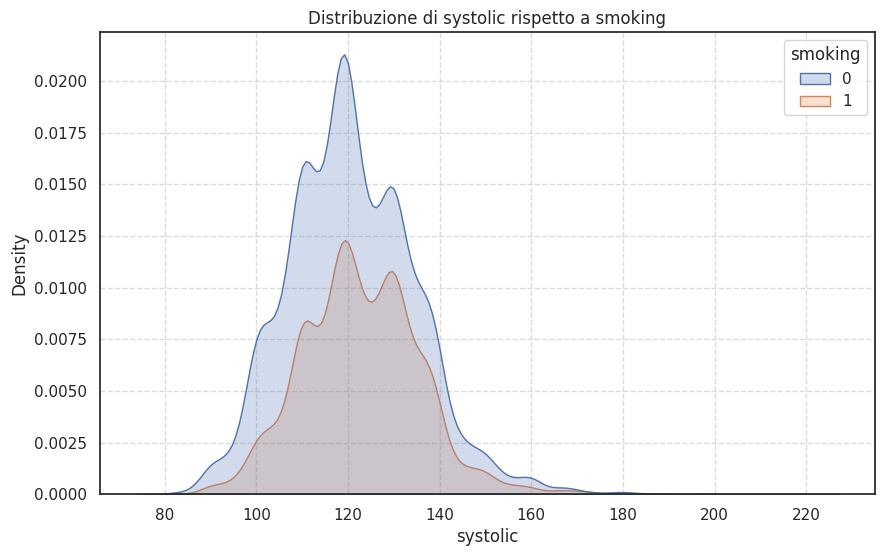

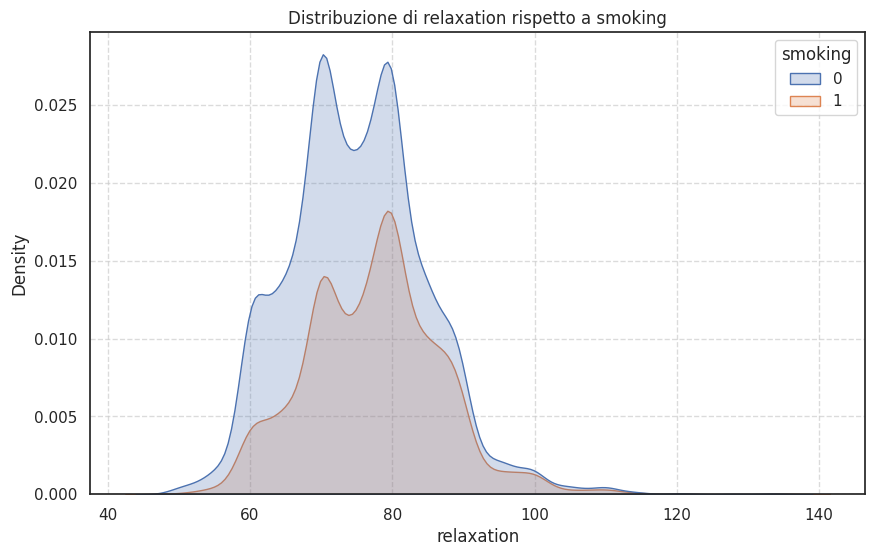

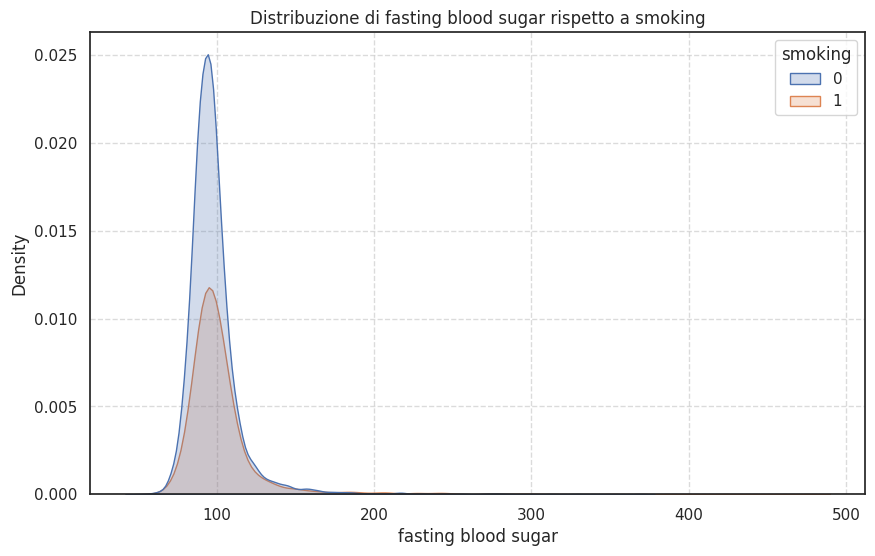

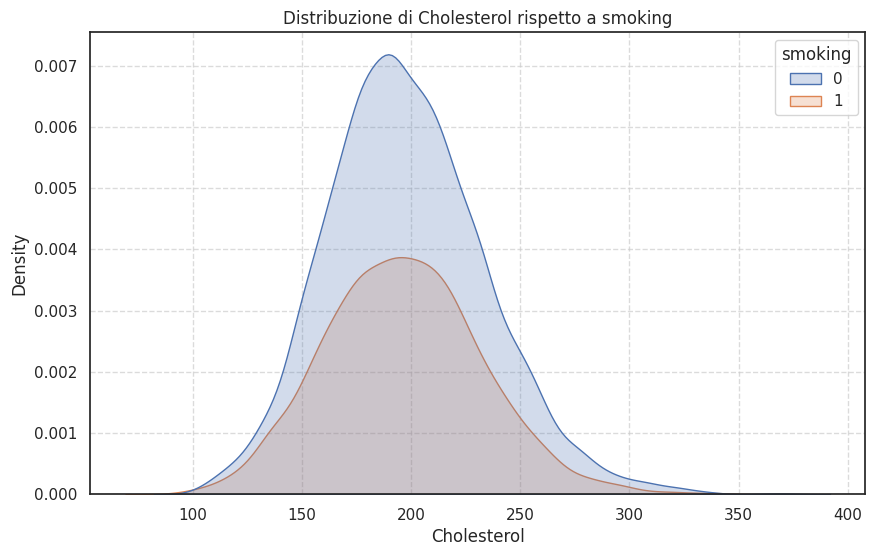

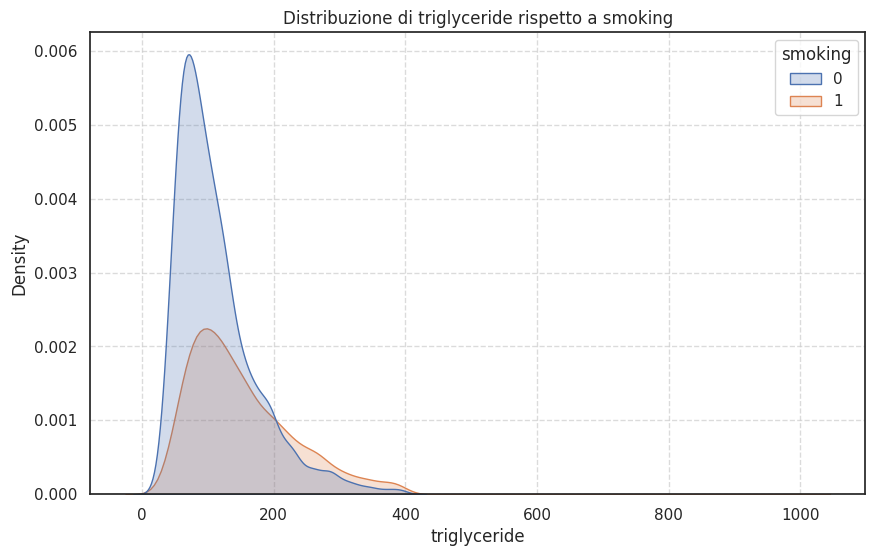

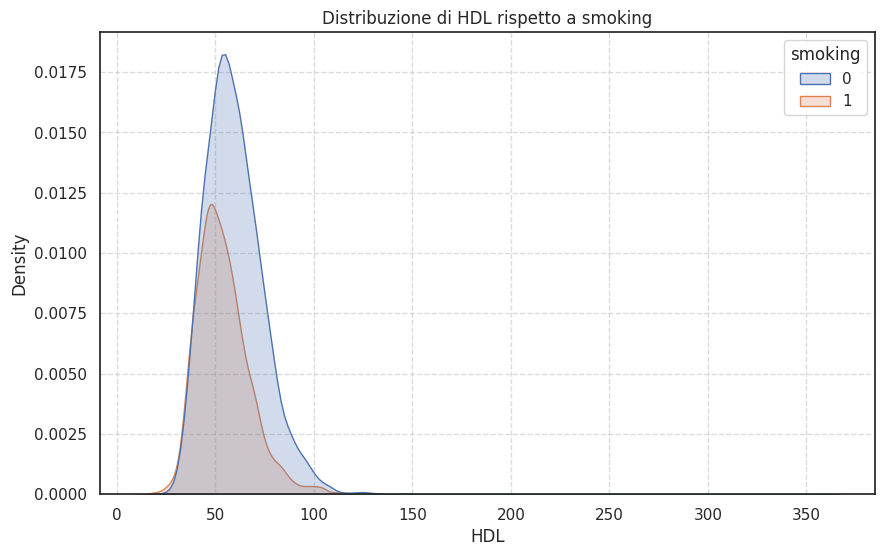

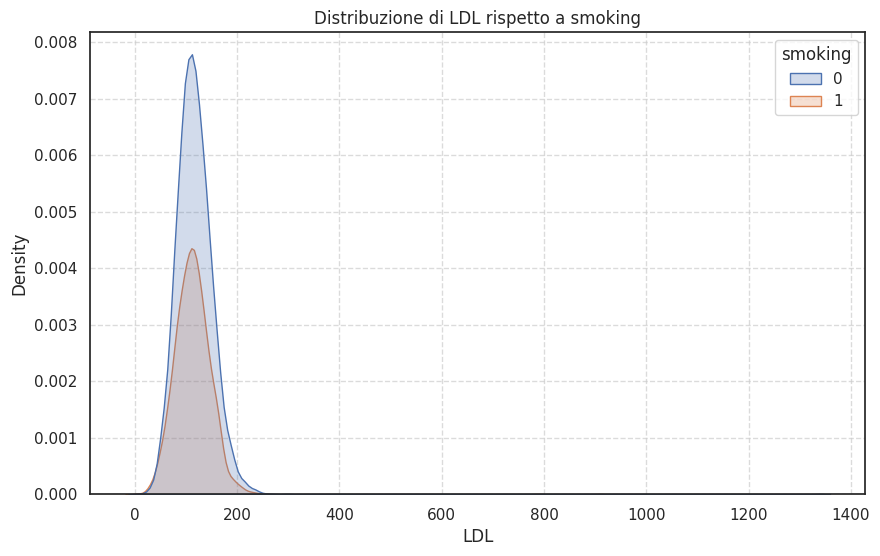

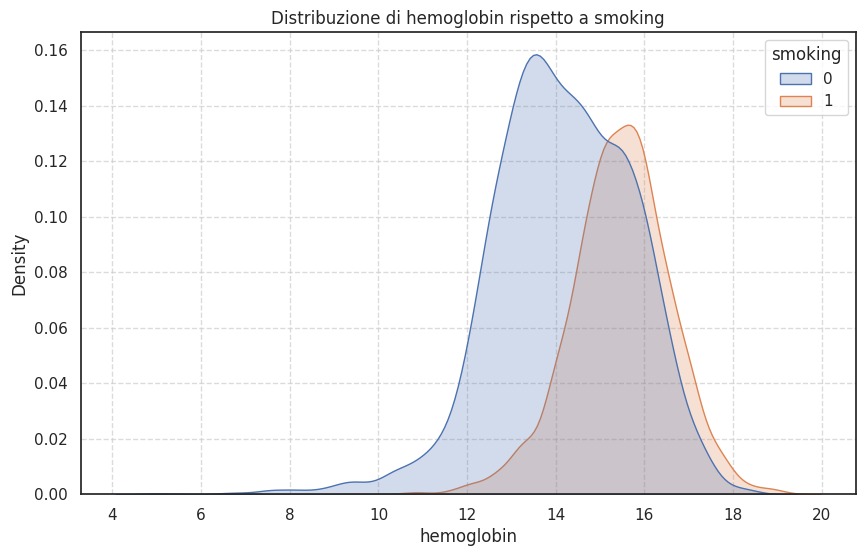

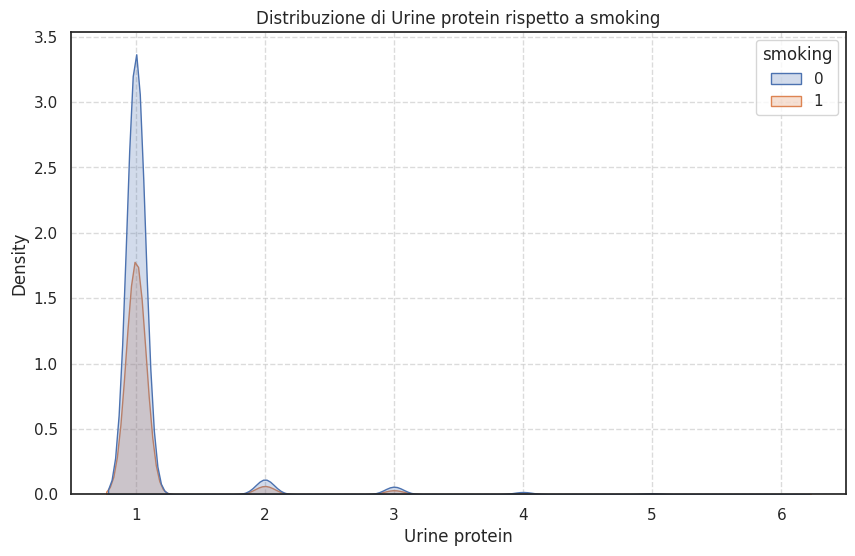

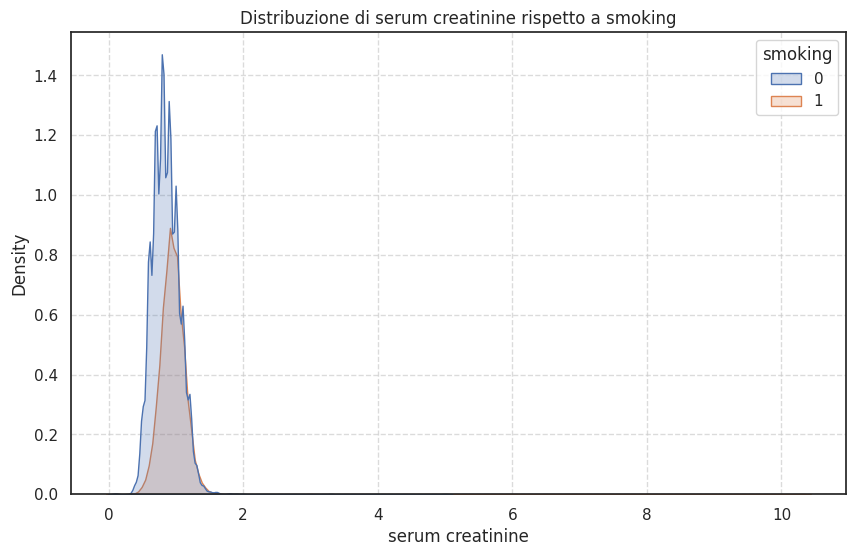

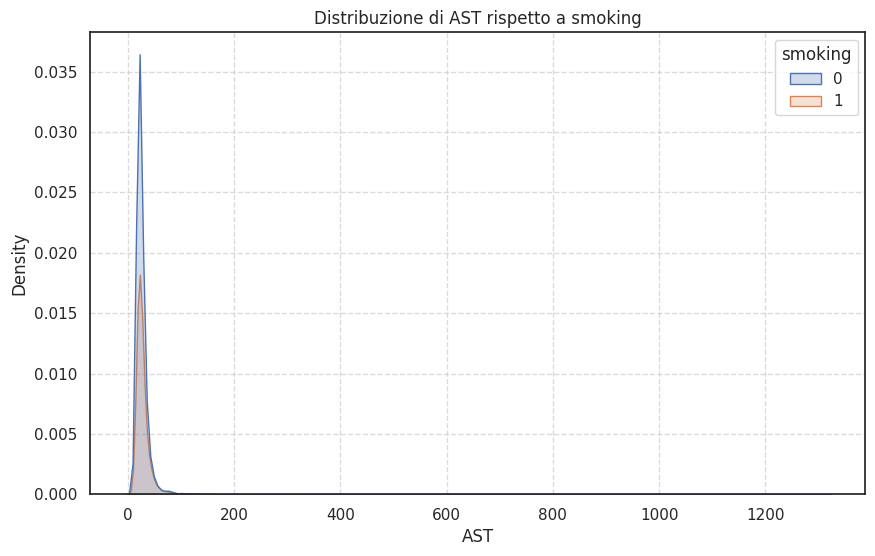

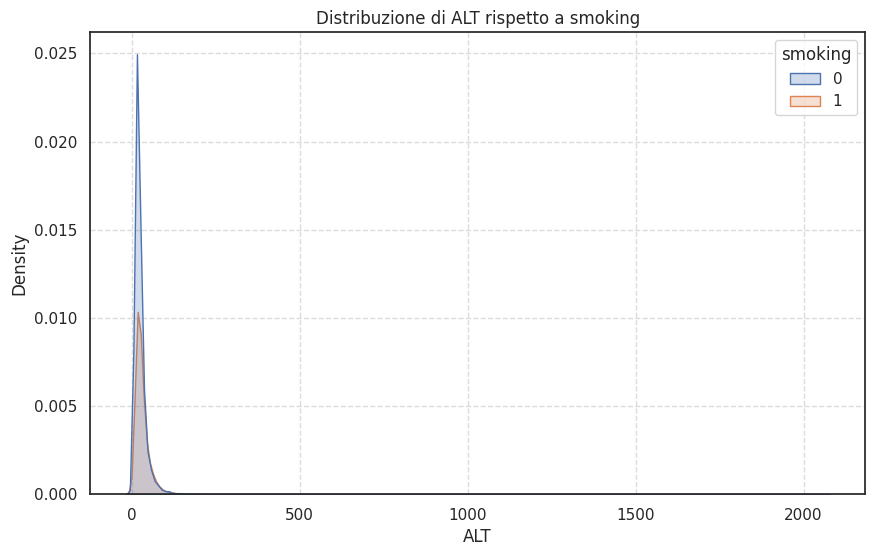

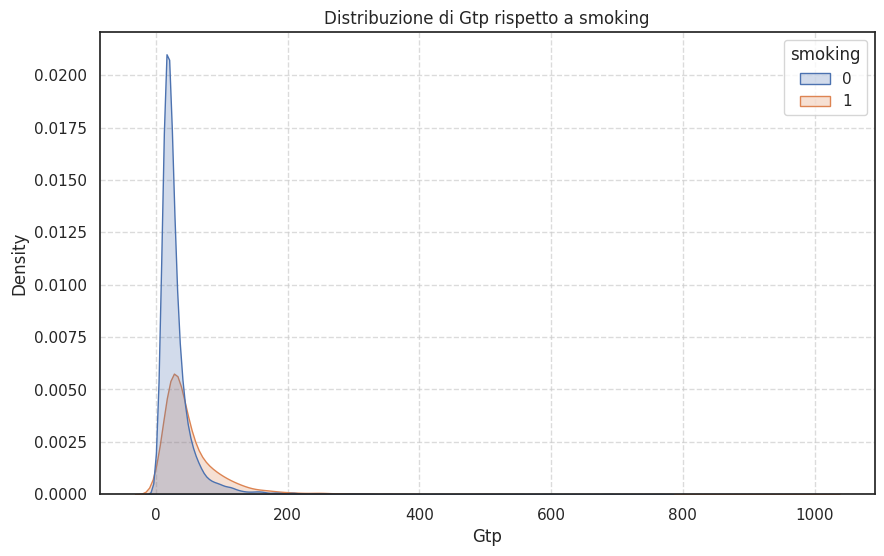

In [ ]:
import seaborn as sns

#Creiamo i grafici bivariati per gli attributi continui
for attributo in attributi_continui:
    plt.figure(figsize=(10, 6))

    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(True, linestyle='--', alpha=0.7)

    sns.kdeplot(data=df, x=attributo, hue='smoking', fill=True)
    plt.title(f'Distribuzione di {attributo} rispetto a smoking')
    plt.show()

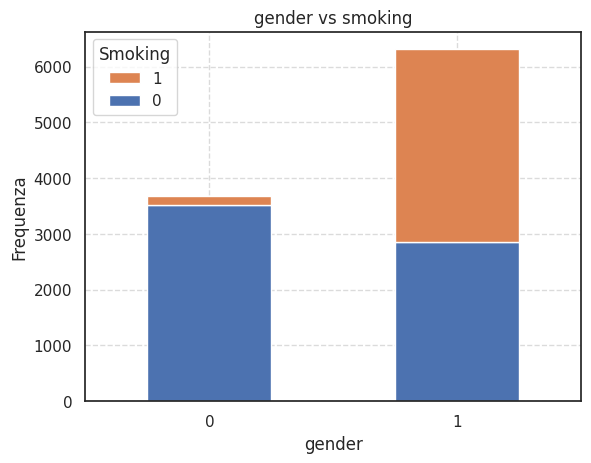

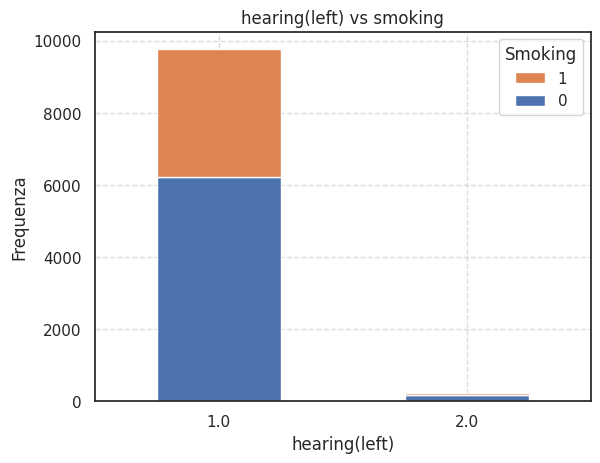

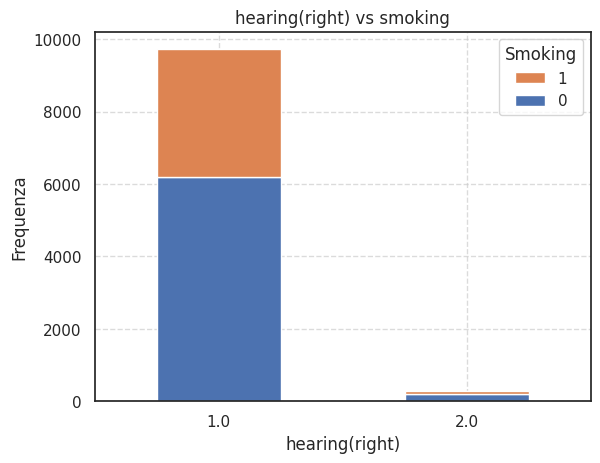

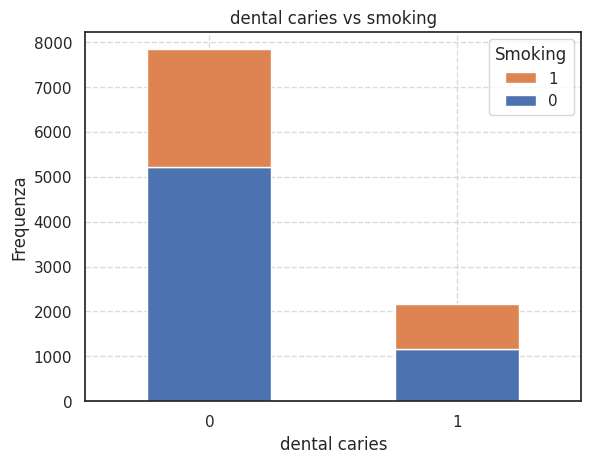

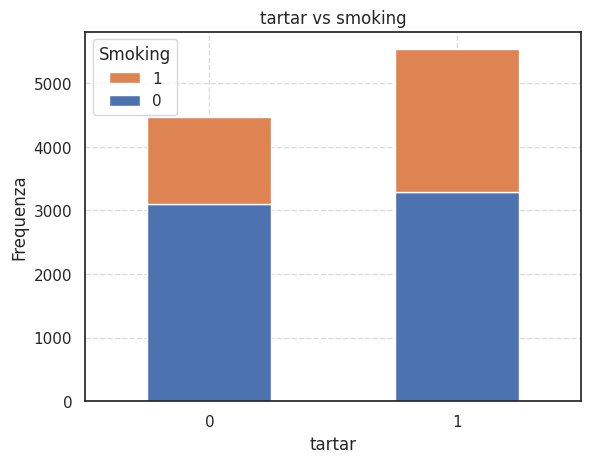

In [ ]:
#Creiamo i grafici bivariati per gli attributi discreti (in questo caso sotto forma di istogrammi per favorire la leggibilità)
for attributo in attributi_discreti:
    grouped = df.groupby([attributo, 'smoking']).size().unstack()

    ax = grouped.plot(kind='bar', stacked=True)

    ax.set_facecolor('white')
    ax.grid(True, linestyle='--', alpha=0.7)

    ax.set_title(f'{attributo} vs smoking')
    ax.set_xlabel(f'{attributo}')
    ax.set_ylabel('Frequenza')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Smoking')

    plt.show()

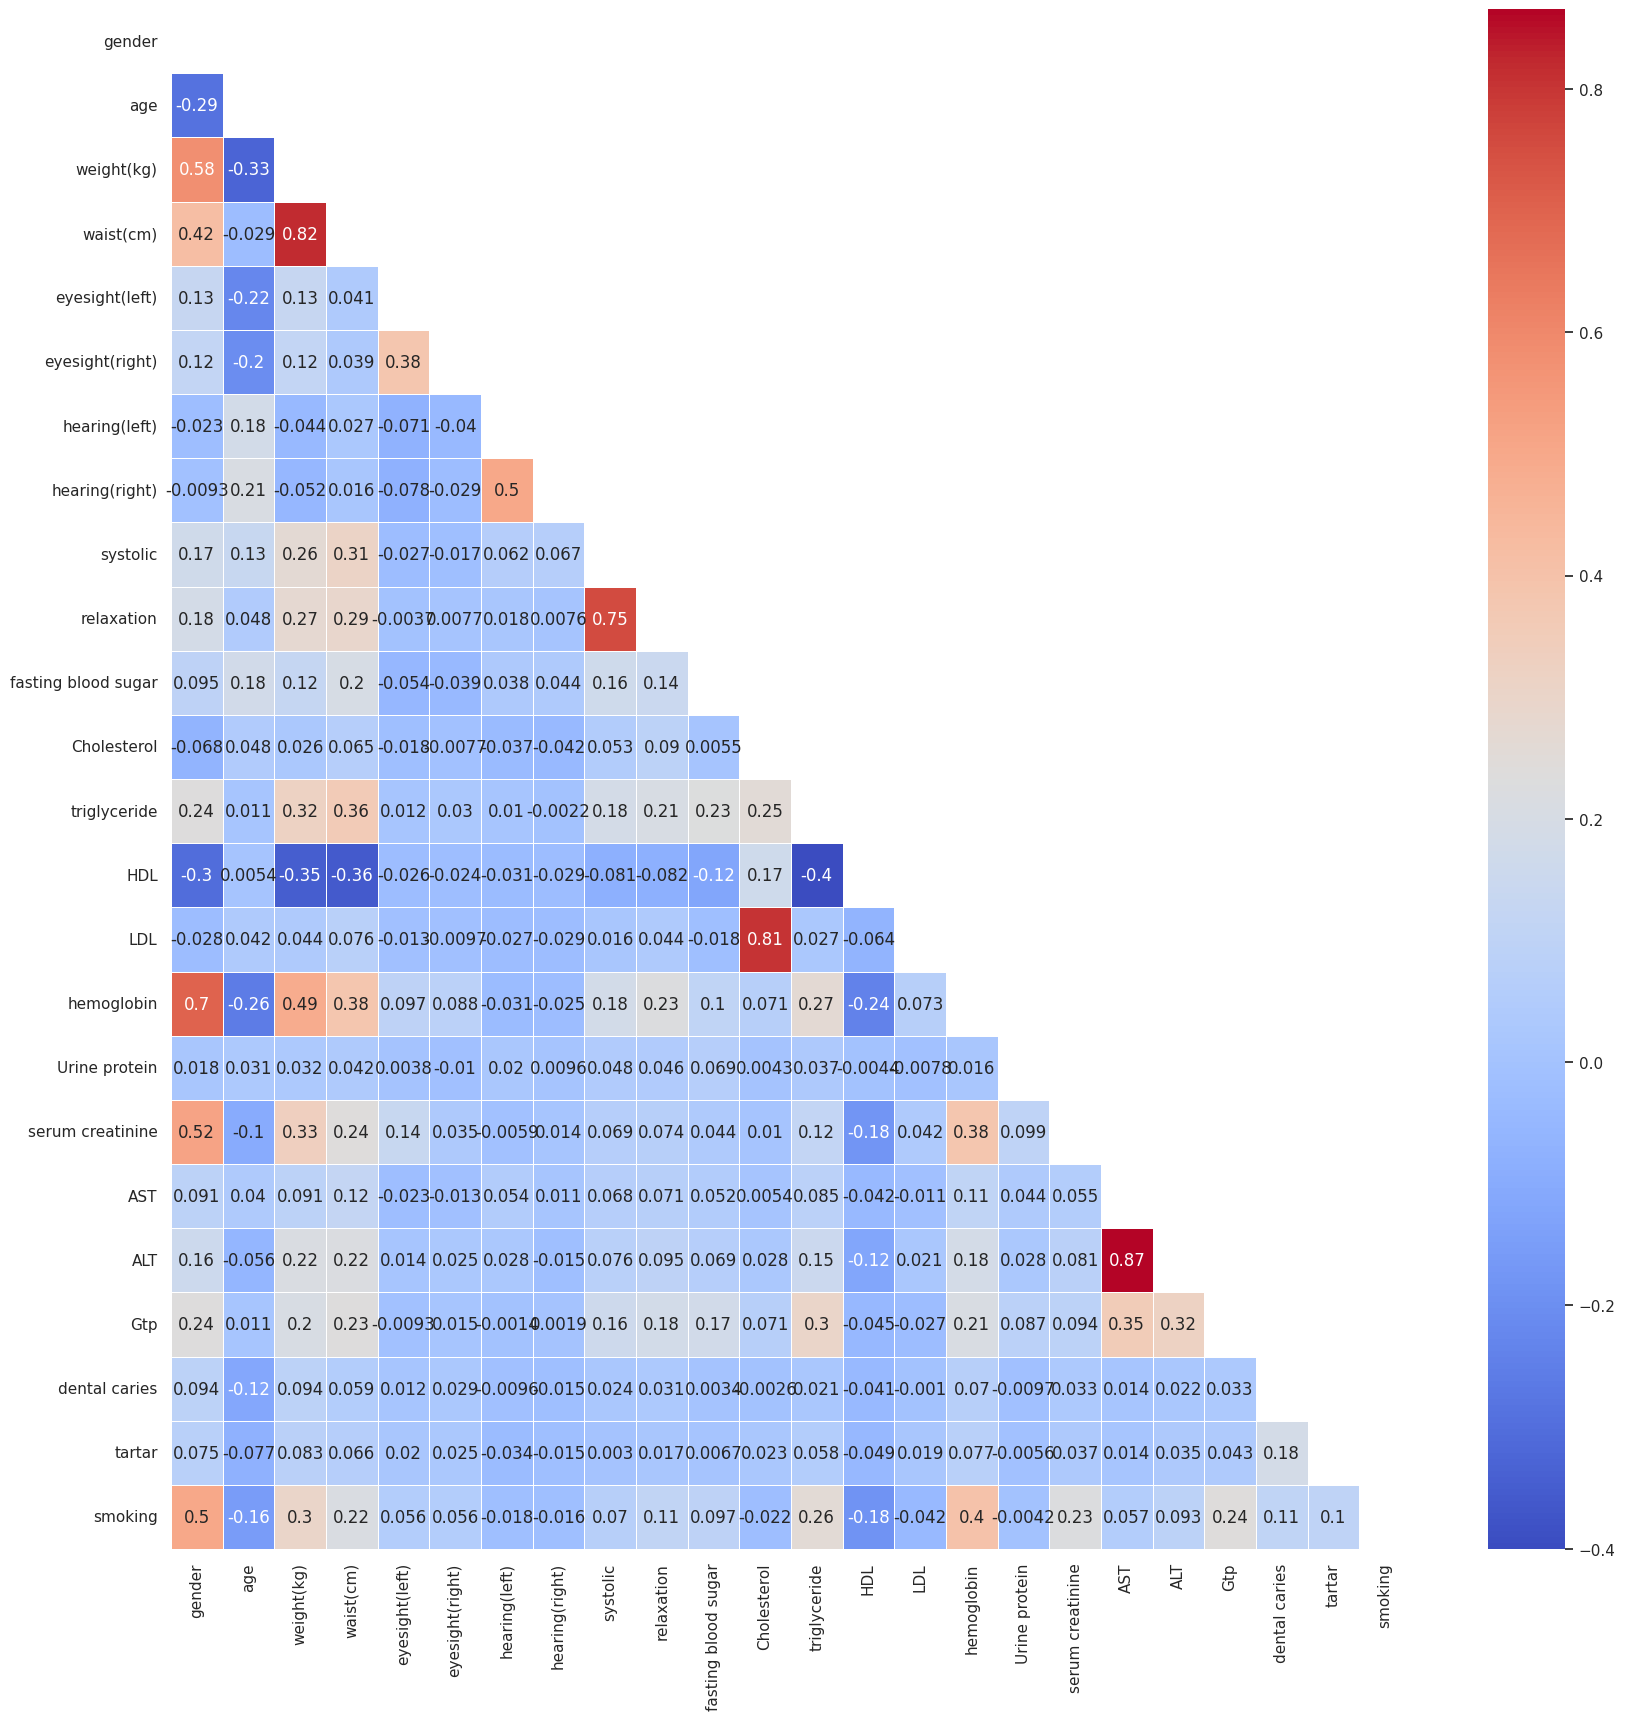

In [ ]:
# Calcoliamo la matrice di correlazione
import numpy as np

correlation_matrix = df.corr()
sns.set(style="white")
plt.figure(figsize=(20, 20))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, mask=mask)

plt.show()

Notiamo:

- forte correlazione positiva tra gender, weight, waist, triglyceride, hemoglobin, serum creatinine, gtp e la variabile target

- forte correlazione negativa tra hdl e variabile target

## PCA

Dato l'elevato numero di attributi nel dataset, intendiamo ridurre la sua dimensionalità identificando le componenti principali che catturano la maggior parte della variazione dei dati.

In [7]:
#Escludiamo la colonna target dalle colonne sottoposte alla PCA
variabili_pca = list(df.columns[:-1])
print(variabili_pca)

['gender', 'age', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'tartar']


In [8]:
#Standardizziamo le colonne su cui andiamo a lavorare
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[variabili_pca])
scaled_data

array([[-1.30824185, -0.3498111 , -0.4533991 , ..., -0.25219847,
        -0.5252006 ,  0.89833802],
       [-1.30824185, -0.3498111 , -0.4533991 , ..., -0.42709473,
        -0.5252006 ,  0.89833802],
       [ 0.76438466,  0.89300428, -0.4533991 , ..., -0.34936306,
        -0.5252006 , -1.11316673],
       ...,
       [ 0.76438466,  1.30727608, -0.06260518, ..., -0.21333263,
        -0.5252006 ,  0.89833802],
       [ 0.76438466, -0.7640829 , -0.4533991 , ..., -0.40766182,
        -0.5252006 ,  0.89833802],
       [ 0.76438466, -0.7640829 ,  1.89136437, ..., -0.23276555,
        -0.5252006 ,  0.89833802]])

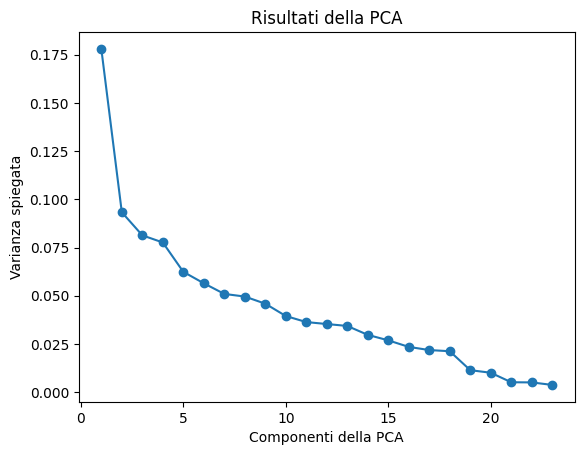

In [9]:
pca = PCA().fit(scaled_data)

# Creiamo un grafico della varianza spiegata per ogni componente
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()

In [10]:
# Applica la PCA per ridurre la dimensionalità dei dati
pca = PCA(n_components=12).fit(scaled_data)
pca_data = pca.transform(scaled_data)
# Quantifichiamo la percentuale di varianza spiegata da ciascuno delle componenti.
print(pca.explained_variance_ratio_)

[0.1779699  0.09329927 0.08133556 0.07763173 0.06241215 0.05647984
 0.05095945 0.04959773 0.04589814 0.03951102 0.03636944 0.03535539]


Scegliendo 12 componenti principali otteniamo una varianza che copre l'80% della varianza totale

In [11]:
sum = 0
for data in pca.explained_variance_ratio_:
    sum += data
print(sum)

0.8068196025499773


In [12]:
#Esaminiamo l'incidenza di ciascun attributo sulle componenti principali generate
pca_df = pd.DataFrame(abs(pca.components_[:12]), columns=df.columns[:-1],
                     index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PCA11','PCA12'])
pca_df

,gender,age,weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar
PC1,0.366260,0.110620,0.400539,0.371181,0.073116,0.067477,0.006519,0.011586,0.217621,0.230033,...,0.230236,0.043820,0.347067,0.042375,0.237657,0.157827,0.208873,0.217083,0.062957,0.063812
PC2,0.217294,0.437956,0.136448,0.040644,0.300940,0.254098,0.260309,0.249443,0.277437,0.238034,...,0.025295,0.131649,0.152138,0.066037,0.162115,0.255468,0.204504,0.187376,0.086112,0.069152
PC3,0.051789,0.001124,0.034645,0.043762,0.014510,0.007618,0.146769,0.132298,0.086575,0.116050,...,0.054391,0.583652,0.037951,0.030103,0.002123,0.331610,0.296754,0.128815,0.001036,0.026415
PC4,0.078511,0.151881,0.077590,0.113247,0.077919,0.076751,0.213192,0.249231,0.262622,0.214570,...,0.148789,0.248919,0.017230,0.008996,0.053523,0.498954,0.491844,0.200794,0.018141,0.046209
PC5,0.133535,0.054383,0.017949,0.031294,0.021170,0.017359,0.464194,0.472970,0.408642,0.437299,...,0.192139,0.220045,0.106798,0.012524,0.224388,0.003197,0.008916,0.089419,0.004307,0.019736
PC6,0.016080,0.090532,0.049488,0.105975,0.450027,0.486464,0.317167,0.309161,0.271204,0.273910,...,0.290943,0.049162,0.002229,0.012102,0.001637,0.079675,0.062074,0.020870,0.009847,0.063811
PC7,0.025565,0.130499,0.009354,0.033662,0.231096,0.187851,0.097976,0.103217,0.092657,0.099674,...,0.126631,0.011090,0.038716,0.161077,0.065171,0.023207,0.016633,0.039357,0.640157,0.580348
PC8,0.251115,0.078071,0.000110,0.095062,0.281855,0.397814,0.014553,0.010891,0.098879,0.100857,...,0.306400,0.053828,0.247722,0.107663,0.360645,0.058841,0.019834,0.069077,0.208386,0.287820
PC9,0.051241,0.081630,0.160917,0.167661,0.093545,0.039733,0.044088,0.011806,0.066094,0.062987,...,0.207781,0.051922,0.030805,0.751054,0.250391,0.072647,0.131727,0.245077,0.163931,0.215806
PC10,0.206430,0.040155,0.223533,0.263637,0.002726,0.044130,0.025477,0.049448,0.053437,0.035274,...,0.309433,0.105613,0.253224,0.569341,0.098266,0.074504,0.126777,0.373191,0.047131,0.012278


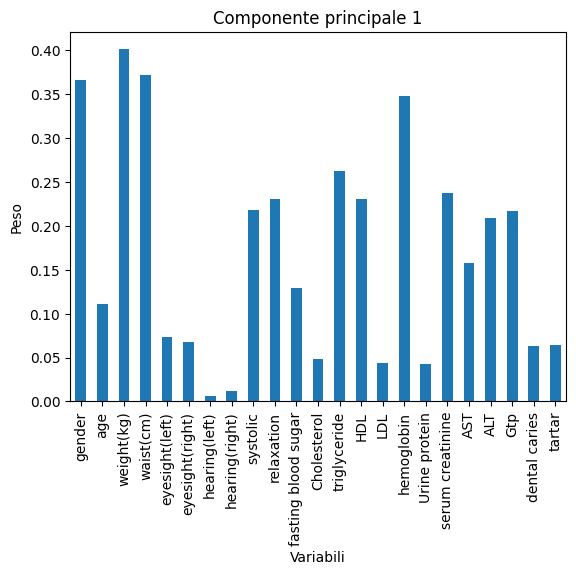

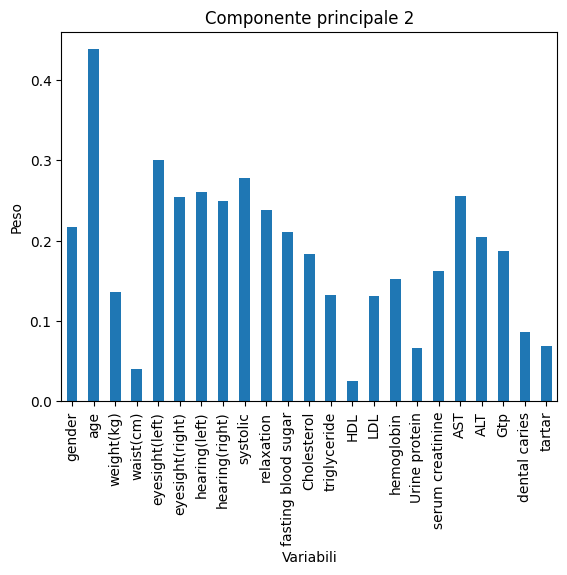

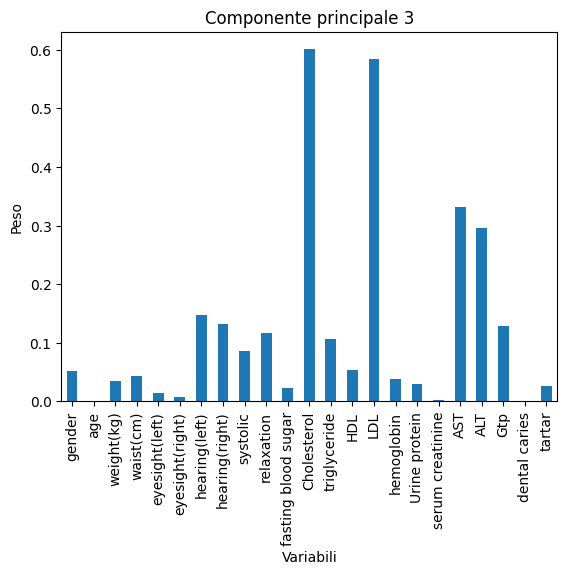

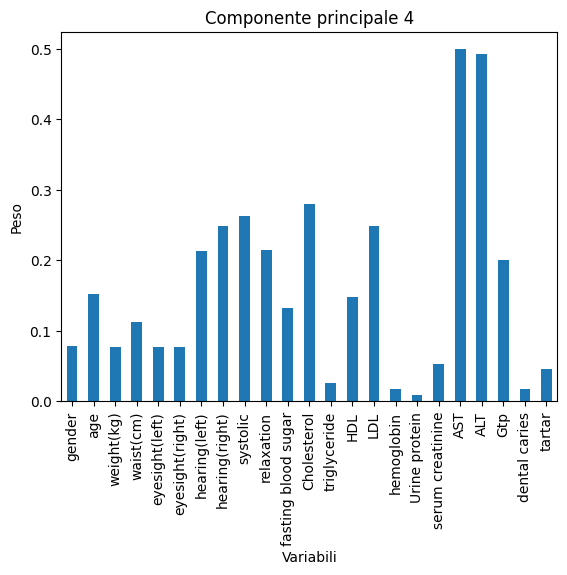

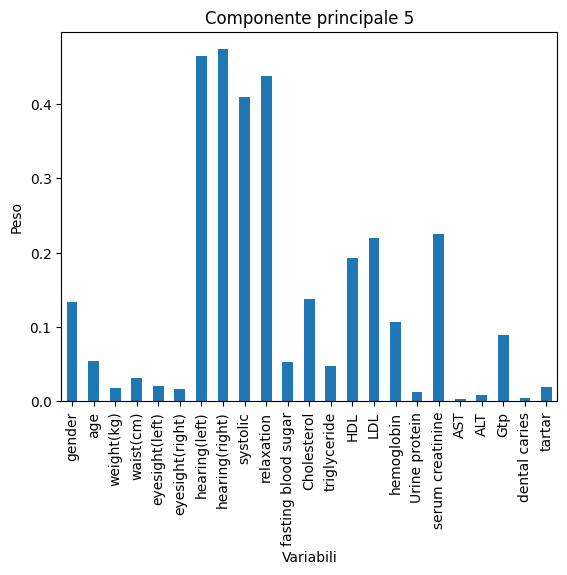

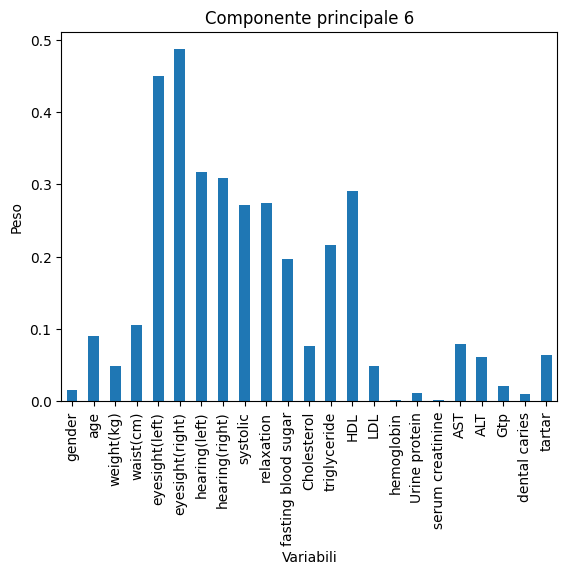

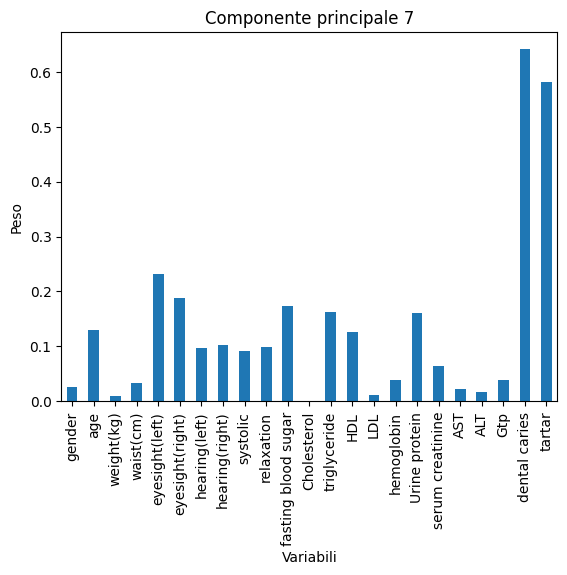

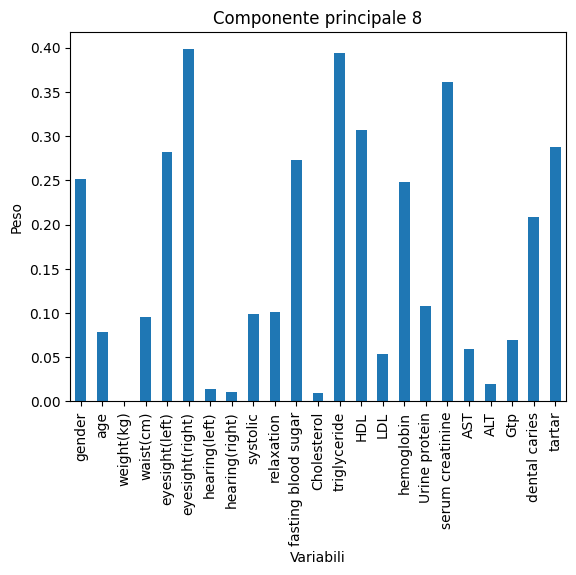

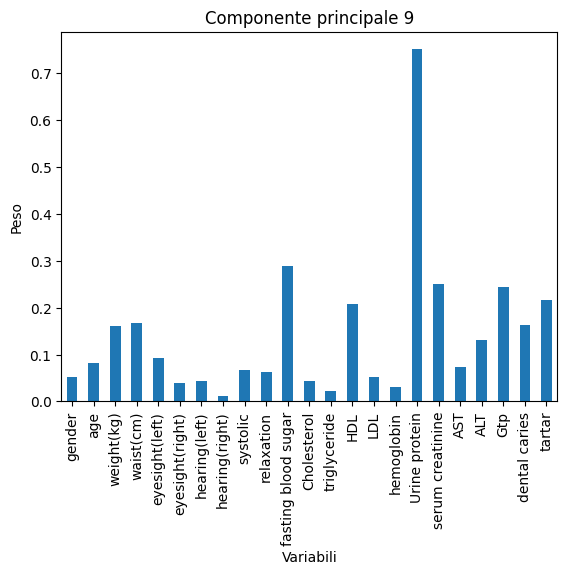

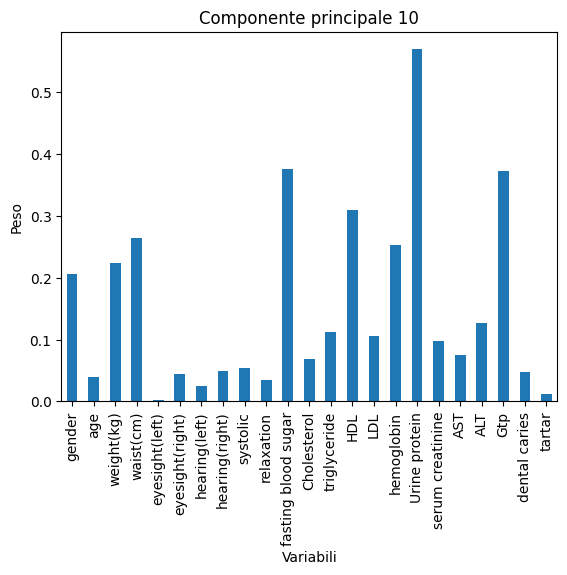

In [13]:
#Vediamo anche graficamente l'incidenza degli attributi
for i in range(10):
    ax = pca_df.iloc[i].plot(kind='bar')
    ax.set_xlabel('Variabili')
    ax.set_ylabel('Peso')
    ax.set_title('Componente principale {}'.format(i+1))
    plt.show()

In [14]:
#Creiamo un nuovo dataframe con le componenti principali
df_pca = pd.DataFrame(data = pca_data,
                      columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PCA11','PCA12'])

#Aggiungiamo la colonna target al nuovo dataframe
df_pca['target'] = df['smoking']

In [15]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PCA11,PCA12,target
0,-1.940127,-0.146684,-0.697083,0.665727,-0.354449,0.379902,-0.311709,0.590367,-0.065169,0.194414,-0.024440,-0.796990,0
1,-1.427304,0.719991,-0.155701,-0.125231,-0.184540,-1.472180,-0.069877,1.478431,-0.311599,0.386917,0.305107,-0.184195,0
2,0.731397,1.088112,-1.815796,-0.518947,-0.260305,0.110661,0.724632,-1.294225,-0.485544,-0.370718,0.533828,0.189851,1
3,1.061086,-0.922229,-3.913328,2.186526,2.854848,-0.340259,0.871844,1.550182,0.027634,0.018216,0.556526,-0.541433,0
4,-2.064388,-0.064950,0.062343,-0.155415,-0.772715,0.234646,0.666760,0.146440,-1.141079,0.999583,-1.024013,-0.198395,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.847253,-1.749666,-0.582905,0.149497,-0.149248,0.594480,-2.103304,-0.405224,0.311686,-0.002684,-0.378170,0.347677,0
9996,1.775642,-2.038633,0.599473,-0.106302,-0.193403,0.718517,1.074626,0.101298,-1.363769,0.778192,-1.622088,-0.135256,1
9997,0.504183,-0.468292,1.507950,-1.235672,0.974221,-2.313054,0.078334,-0.535428,0.415148,-0.723469,1.637330,-0.314293,1
9998,0.055312,-0.935778,-1.255484,0.065262,0.082702,0.477870,-0.248245,0.088848,-0.370521,0.203082,0.949117,-0.834652,0


Abbiamo ottenuto un nuovo dataset con lo stesso numero di righe del precedente ma con sole 13 features al posto che 24

Ora procediamo con l'addestramento dei modelli.

Abbiamo scelto di utilizzare gli alberi decisionali e le SVM.

Valuteremo entrambi i modelli sia con l'applicazione di PCA che senza.

## Modelli

In [ ]:
#Suddivdiamo il dataset in training set e test set (con test size del 30%)
from sklearn.model_selection import train_test_split

X = df.drop('smoking', axis=1)
y = df['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split

X = df_pca.drop('target', axis=1)
y = df_pca['target']

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, test_size=0.3, random_state=42)

### Alberi di decisione

#### Albero di Decisione

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Fai le predizioni sul set di test
y_true = np.ones(len(y_test))
y_pred_tree = np.ones(len(y_test))

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred_tree)

# Stampa la matrice di confusione
print("Matrice di Confusione:")
print(cm)

Matrice di Confusione:
[[   0 1941]
 [   0 1059]]


Facciamo training albero

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from time import time

model_tree = DecisionTreeClassifier(random_state=42)
start_time = time()
model_tree.fit(X_train, y_train)
end_time = time()
DecisionTreeNoPCA_training_time = end_time - start_time

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(model_tree, filled=True, ax=ax)
plt.plot()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import classification_report

# predizione del nuovo modello
y_pred = model_tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)

print("Test Set Performance:")
print(classification_report(y_test, y_pred))

Confusion matrix:
 [[1442  499]
 [ 429  630]]
Test Set Performance:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1941
           1       0.56      0.59      0.58      1059

    accuracy                           0.69      3000
   macro avg       0.66      0.67      0.67      3000
weighted avg       0.70      0.69      0.69      3000



In [ ]:
# andiamo a lavorare sul parametro di complessità, che stima il vantaggio di aggiungere/togliere degli split
# in funzione degli errori di classificazione
# più il modello è complesso e più viene penalizzato
path = model_tree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

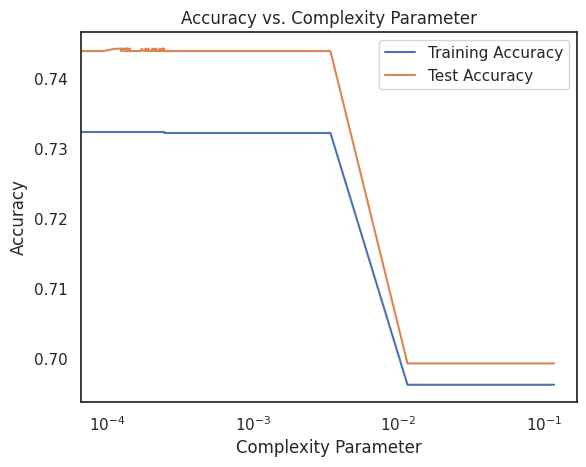

In [ ]:
# valori di complessità candidati ad essere tagliati dal modello
ccp_alphas = path.ccp_alphas

# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.11735577440370953


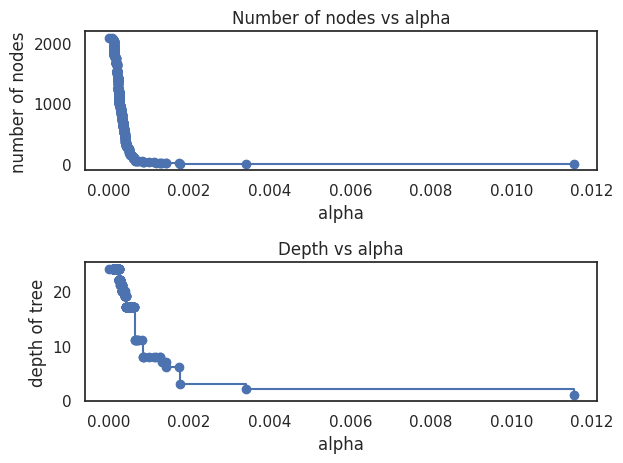

In [ ]:
clfs = clfs[:-1]
complexity_values = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(complexity_values, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(complexity_values, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [ ]:
# Potiamo albero con alpha=0.001
clf_pruned = DecisionTreeClassifier(max_depth=3, ccp_alpha=0.001)
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=3)

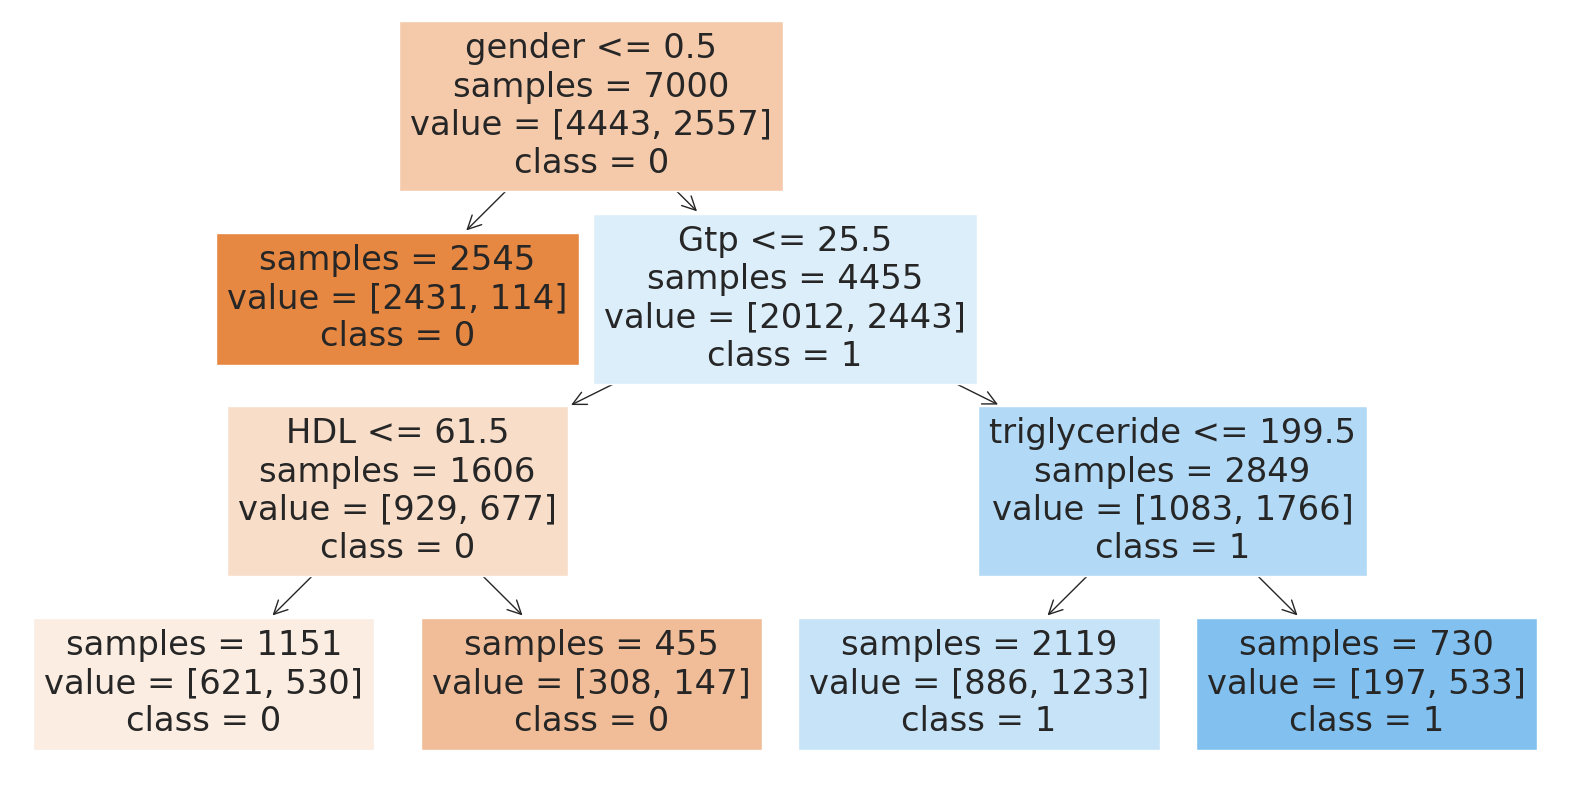

Test Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1941
           1       0.62      0.70      0.66      1059

    accuracy                           0.74      3000
   macro avg       0.72      0.73      0.73      3000
weighted avg       0.75      0.74      0.75      3000



In [ ]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(clf_pruned,
          feature_names=X_train.columns,
          class_names=[str(x) for x in clf_pruned.classes_],
          filled=True,
          ax=ax,
          impurity=False)

plt.show()

y_pred = clf_pruned.predict(X_test)

cm_tree = confusion_matrix(y_test, y_pred)
accuracy_pruned = clf_pruned.score(X_test, y_test)

print("Test Set Performance:")
print(classification_report(y_test, y_pred))

<Axes: >

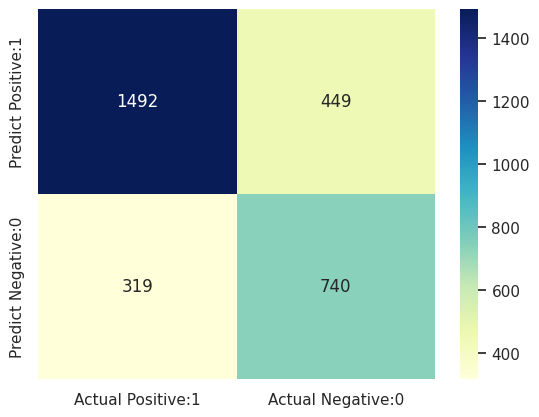

In [ ]:
import seaborn as sns

cm_matrix = pd.DataFrame(data=cm_tree, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### Albero di decisione con PCA

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

tree_pca = DecisionTreeClassifier(random_state=42)
start_time = time()
tree_pca.fit(X_train_pca, y_train_pca)
end_time = time()
DecisionTreePCA_training_time = end_time - start_time

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(tree_pca, filled=True, ax=ax)
plt.plot()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
y_pred = tree_pca.predict(X_test_pca)

cm = confusion_matrix(y_test_pca, y_pred)
print("Confusion matrix:\n", cm)

print("Test Set Performance:")
print(classification_report(y_test_pca, y_pred))

Confusion matrix:
 [[1438  503]
 [ 477  582]]
Test Set Performance:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1941
           1       0.54      0.55      0.54      1059

    accuracy                           0.67      3000
   macro avg       0.64      0.65      0.64      3000
weighted avg       0.68      0.67      0.67      3000



In [ ]:
path = tree_pca.cost_complexity_pruning_path(X_train_pca, y_train_pca)

ccp_alphas = path.ccp_alphas

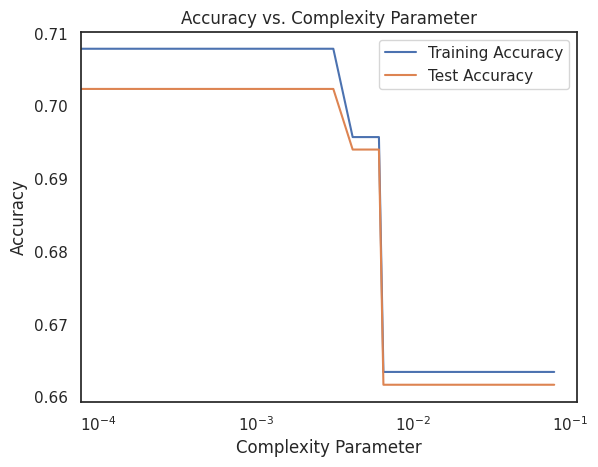

In [ ]:
ccp_alphas = path.ccp_alphas

# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    tree_pca = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
    tree_pca.fit(X_train_pca, y_train_pca)
    train_accuracy.append(tree_pca.score(X_train_pca, y_train_pca))
    test_accuracy.append(tree_pca.score(X_test_pca, y_test_pca))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    tree_pca = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree_pca.fit(X_train_pca, y_train_pca)
    clfs.append(tree_pca)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.07930505944493016


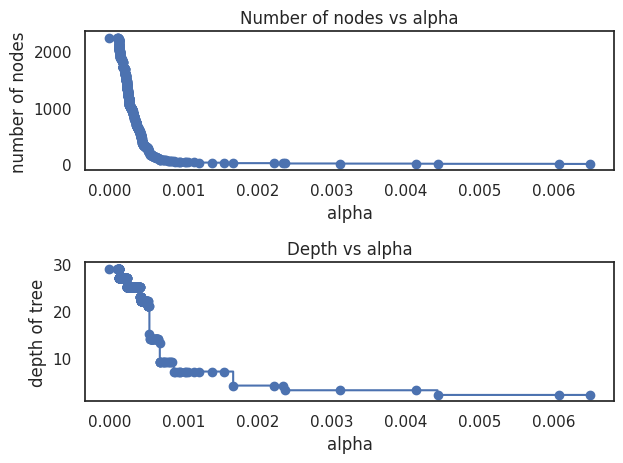

In [ ]:
clfs = clfs[:-1]
complexity_values = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(complexity_values, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(complexity_values, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [ ]:
# Potiamo albero con alpha=0.001
tree_pca = DecisionTreeClassifier(max_depth=3, ccp_alpha=0.001)
tree_pca.fit(X_train_pca, y_train_pca)

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=3)

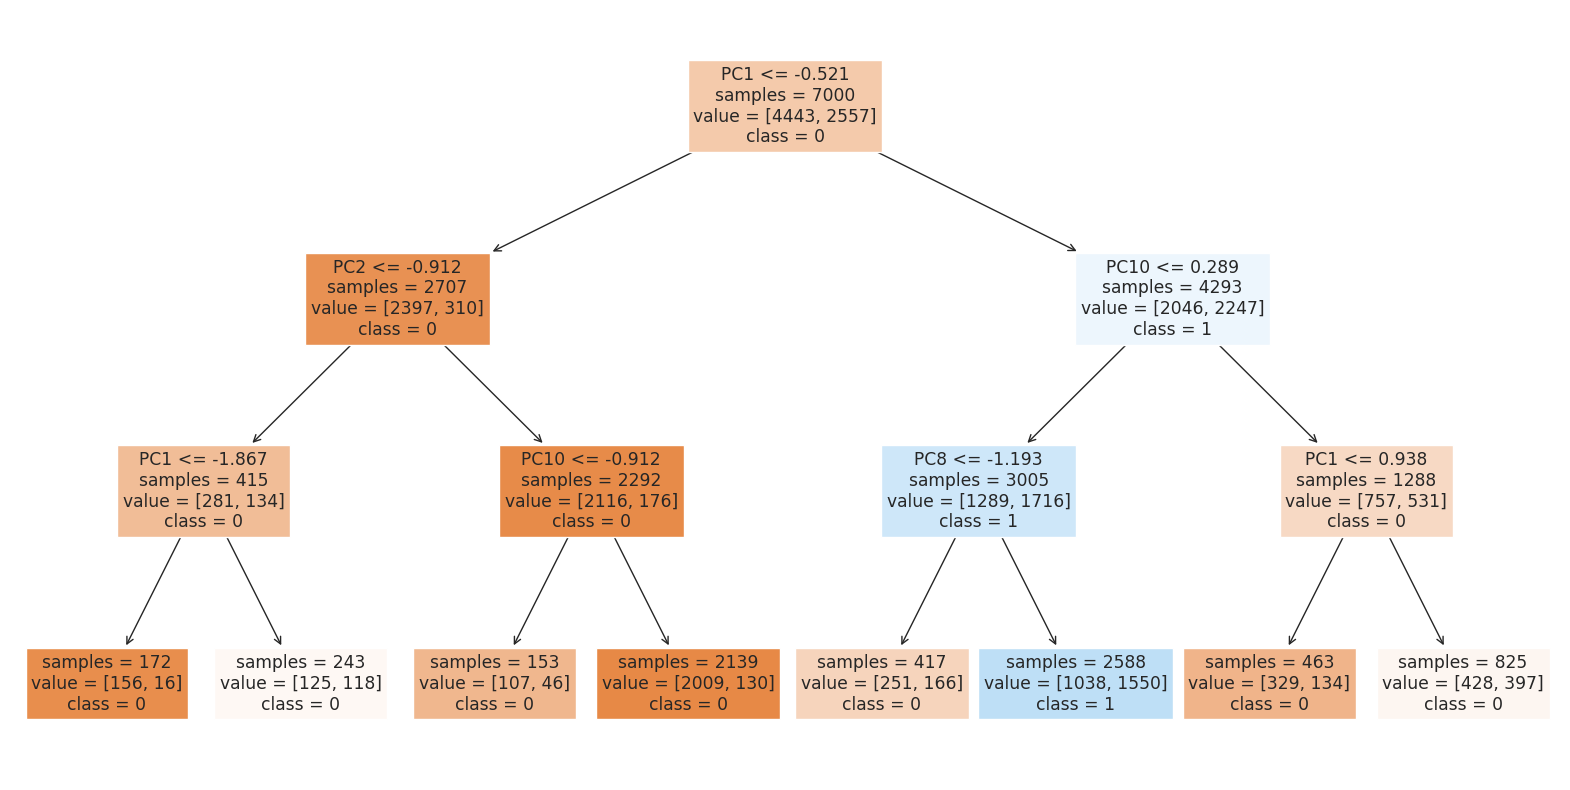

Test Set Performance:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1941
           1       0.58      0.60      0.59      1059

    accuracy                           0.70      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.70      0.70      0.70      3000



In [ ]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(tree_pca,
          feature_names=X_train_pca.columns,
          class_names=[str(x) for x in tree_pca.classes_],
          filled=True,
          ax=ax,
          impurity=False)

plt.show()

y_pred = tree_pca.predict(X_test_pca)

cm_tree_pca = confusion_matrix(y_test_pca, y_pred)

print("Test Set Performance:")
print(classification_report(y_test_pca, y_pred))

<Axes: >

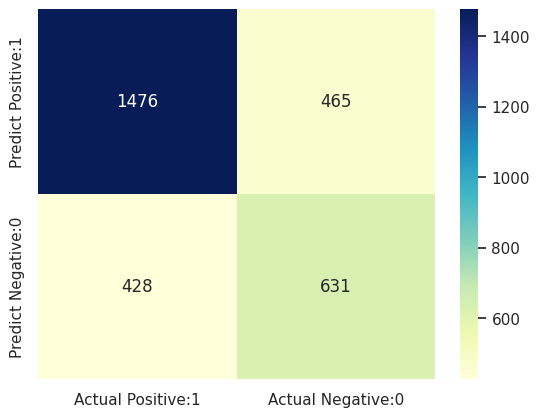

In [ ]:
import seaborn as sns

cm_matrix = pd.DataFrame(data=cm_tree_pca, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### Confronto tra i due alberi con curva ROC

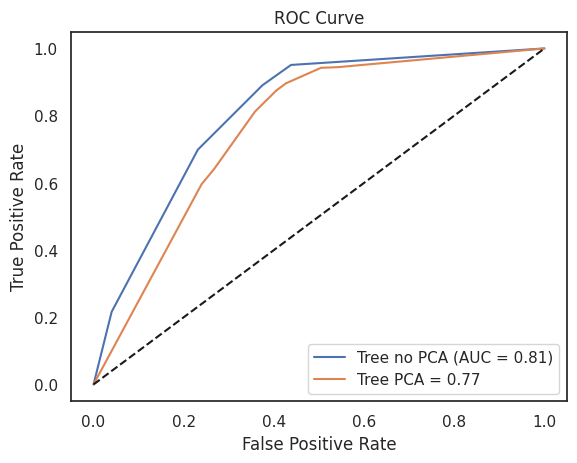

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcola le probabilità predette per la classe positiva
y_pred_prob_tree = clf_pruned.predict_proba(X_test)[:, 1]
y_pred_prob_tree_pca = tree_pca.predict_proba(X_test_pca)[:,-1]

# utilizzando clf_pruned.predict(X_test), si ottengono solo le predizioni di classe effettive, che non forniscono le informazioni necessarie per costruire la curva ROC e calcolare l'AUC.

# Calcola la curva ROC e l'AUC di albero senza PCA
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_pred_prob_tree)
auc_tree = roc_auc_score(y_test, y_pred_prob_tree)

# Calcola la curva ROC e l'AUC di albero con PCA
fpr_tree_pca, tpr_tree_pca, thresholds_tree_pca = roc_curve(y_test_pca, y_pred_prob_tree_pca)
auc_tree_pca = roc_auc_score(y_test_pca, y_pred_prob_tree_pca)

# Plotta la curva ROC dei due modelli per comparare le performance
plt.plot(fpr_tree, tpr_tree, label=f'Tree no PCA (AUC = {auc_tree:.2f})')
plt.plot(fpr_tree_pca, tpr_tree_pca, label=f'Tree PCA (AUC = {auc_tree_pca:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

###SVM

#### SVM senza PCA

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Al crescere del valore di C aumenta la complessità dell'iperpiano -> rischio overfitting
svm_model = svm.SVC(kernel='linear', random_state=42, C=10, probability=True)

start_time = time()
svm_model.fit(X_train, y_train)
end_time = time()
SVMNoPCA_training_time = end_time - start_time

# Effettua le predizioni sul test set
y_pred = svm_model.predict(X_test) # predizione su dati non ancora visti (inferenza)

In [ ]:
# predizione del nuovo modello
y_pred = svm_model.predict(X_test)

cm_svm = confusion_matrix(y_test, y_pred)

print("Test Set Performance:")
print(classification_report(y_test, y_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1302
           1       0.64      0.70      0.67       698

    accuracy                           0.76      2000
   macro avg       0.73      0.74      0.74      2000
weighted avg       0.76      0.76      0.76      2000



<Axes: >

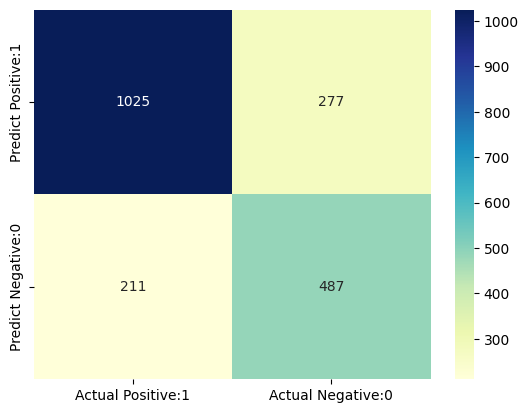

In [ ]:
import seaborn as sns

cm_matrix = pd.DataFrame(data=cm_svm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
print (f"Number of support vectors: {svm_model.support_vectors_.shape[0]}")

Number of support vectors: 3625


In [ ]:
#Per vedere overfitting
y_pred = svm_model.predict(X_train)

# Calcola l'accuratezza del modello
accuracy = accuracy_score(y_train, y_pred)

print('Training set score: {:.4f}'.format(svm_model.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(svm_model.score(X_test, y_test)))

Training set score: 0.7481
Test set score: 0.7560


#### SVM con PCA

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Al crescere del valore di C aumenta la complessità dell'iperpiano -> rischio overfitting
svm_pca = svm.SVC(kernel='linear', random_state=42, C=10, probability=True)

start_time = time()
svm_pca.fit(X_train_pca, y_train_pca)
end_time = time()
SVMPCA_training_time = end_time - start_time

# Effettua le predizioni sul test set
y_pred = svm_pca.predict(X_test_pca) # predizione su dati non ancora visti (inferenza)

In [ ]:
# predizione del nuovo modello
y_pred = svm_pca.predict(X_test_pca)

cm_svm_pca = confusion_matrix(y_test_pca, y_pred)

print("Test Set Performance:")
print(classification_report(y_test_pca, y_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1302
           1       0.61      0.66      0.64       698

    accuracy                           0.74      2000
   macro avg       0.71      0.72      0.72      2000
weighted avg       0.74      0.74      0.74      2000



<Axes: >

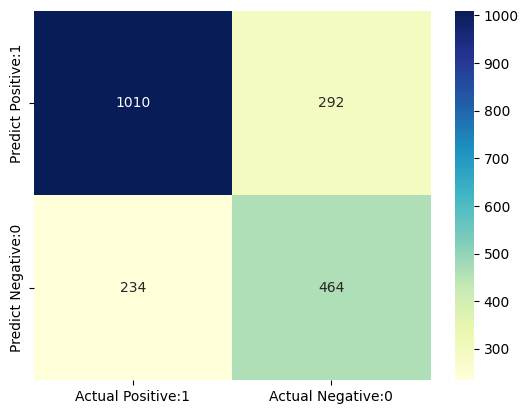

In [ ]:
import seaborn as sns

cm_matrix = pd.DataFrame(data=cm_svm_pca, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
print (f"Number of support vectors: {svm_pca.support_vectors_.shape[0]}")

Number of support vectors: 4895


In [ ]:
y_pred = svm_pca.predict(X_train_pca)

# Calcola l'accuratezza del modello
accuracy = accuracy_score(y_train_pca, y_pred)

print('Training set score: {:.4f}'.format(svm_pca.score(X_train_pca, y_train_pca)))

print('Test set score: {:.4f}'.format(svm_pca.score(X_test_pca, y_test_pca)))

Training set score: 0.7255
Test set score: 0.7370


#### Confronto tra i due modelli SVM con curva ROC

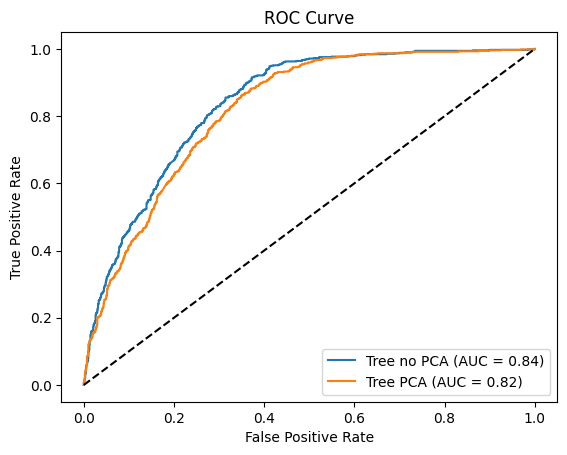

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcola le probabilità predette per la classe positiva
y_pred_prob_svm = svm_model.predict_proba(X_test)[:, 1]
y_pred_prob_svm_pca = svm_pca.predict_proba(X_test_pca)[:,-1]

# utilizzando clf_pruned.predict(X_test), si ottengono solo le predizioni di classe effettive, che non forniscono le informazioni necessarie per costruire la curva ROC e calcolare l'AUC.

# Calcola la curva ROC e l'AUC della SVM senza PCA
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_prob_svm)
auc_svm = roc_auc_score(y_test, y_pred_prob_svm)

# Calcola la curva ROC e l'AUC della SVM con PCA
fpr_svm_pca, tpr_svm_pca, thresholds_svm_pca = roc_curve(y_test_pca, y_pred_prob_svm_pca)
auc_svm_pca = roc_auc_score(y_test_pca, y_pred_prob_svm_pca)

# Plotta la curva ROC dei due modelli per comparare le performance
plt.plot(fpr_svm, tpr_svm, label=f'SVM no PCA (AUC = {auc_svm:.2f})')
plt.plot(fpr_svm_pca, tpr_svm_pca, label=f'SVM PCA (AUC = {auc_svm_pca:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

###Confronto tempi di Addestramento

In [ ]:
print(f'Tempo di training DecisionTree no PCA: {DecisionTreeNoPCA_training_time:.3f} secondi')
print(f'Tempo di training DecisionTree con PCA: {DecisionTreePCA_training_time:.3f} secondi')

print(f'Tempo di training SVM no PCA: {SVMNoPCA_training_time:.3f} secondi')
print(f'Tempo di training SVM con PCA: {SVMPCA_training_time:.3f} secondi')

##Stratified Cross Validation

###Decision tree No PCA

In [16]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import scipy.stats as st
import numpy as np

In [17]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

In [18]:
y_tree=df['smoking']
df = df.drop('smoking', axis=1)

In [19]:
accuracy_stratified_tree = []

start_time = time()
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df, y_tree)):
        X_train_tree, X_valid_tree = df.iloc[train_idx], df.iloc[valid_idx]
        y_train_tree, y_valid_tree = y_tree[train_idx], y_tree[valid_idx]

        tree = DecisionTreeClassifier(max_depth=3, random_state=42)
        tree.fit(X_train_tree, y_train_tree)

        y_pred_valid_tree = tree.predict(X_valid_tree)
        accuracy_stratified_tree.append(accuracy_score(y_valid_tree,y_pred_valid_tree))
end_time = time()
cv_time_decisiontree = end_time - start_time

In [20]:
accuracy_stratified_tree

[0.717, 0.734, 0.737, 0.714, 0.73, 0.732, 0.735, 0.73, 0.751, 0.756]

In [21]:
st.t.interval(confidence=0.90, df=len(accuracy_stratified_tree)-1, loc=np.mean(accuracy_stratified_tree), scale=st.sem(accuracy_stratified_tree))

(0.7261003996586887, 0.7410996003413114)

###SVM PCA

In [22]:
from sklearn.svm import SVC

In [23]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

In [24]:
y_SVM=df_pca['target']
df_pca = df_pca.drop('target', axis=1)

In [25]:
accuracy_stratified_pca = []

start_time = time()
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_pca, y_SVM)):
        X_train, X_valid = df_pca.iloc[train_idx], df_pca.iloc[valid_idx]
        y_train, y_valid = y_SVM[train_idx], y_SVM[valid_idx]

        svm = SVC(kernel = 'linear', C=10, random_state=42)
        svm.fit(X_train, y_train)

        y_pred_valid = svm.predict(X_valid)
        accuracy_stratified_pca.append(accuracy_score(y_valid,y_pred_valid))
end_time = time()
cv_time_svm_pca = end_time - start_time

In [26]:
accuracy_stratified_pca

[0.721, 0.732, 0.724, 0.724, 0.733, 0.72, 0.71, 0.726, 0.745, 0.734]

In [28]:
st.t.interval(confidence=0.90, df=len(accuracy_stratified_pca)-1, loc=np.mean(accuracy_stratified_pca), scale=st.sem(accuracy_stratified_pca))

(0.7213435877178489, 0.7324564122821509)

###SVM senza PCA

In [30]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

In [ ]:
accuracy_stratified_NOpca = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_pca, y_tree)):
        X_train, X_valid = df.iloc[train_idx], df.iloc[valid_idx]
        y_train, y_valid = y_tree[train_idx], y_tree[valid_idx]

        svm = SVC(kernel = 'linear', C=10, random_state=42)
        svm.fit(X_train, y_train)

        y_pred_valid = svm.predict(X_valid)
        accuracy_stratified_NOpca.append(accuracy_score(y_valid,y_pred_valid))

In [ ]:
accuracy_stratified_NOpca

In [ ]:
st.t.interval(confidence=0.90, df=len(accuracy_stratified_NOpca)-1, loc=np.mean(accuracy_stratified_NOpca), scale=st.sem(accuracy_stratified_NOpca))

##Confronti

####Confronto confusion matrix

In [ ]:
# predizione del nuovo modello
y_pred_tree = tree.predict(X_test_tree)
cm_tree = confusion_matrix(y_test_tree, y_pred_tree)

y_pred_svm_pca = svm.predict(X_test_svm_pca)
cm_svm_pca = confusion_matrix(y_test_svm_pca, y_pred_svm_pca)

In [ ]:
import seaborn as sns

cm_matrix_tree = pd.DataFrame(data=cm_tree, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix_tree, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matrice di confusione albero")
plt.show()

cm_matrix_svm_pca = pd.DataFrame(data=cm_svm_pca, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix_svm_pca, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matrice di confusione svm con pca")
plt.show()

####Confronto intervalli di confidenza

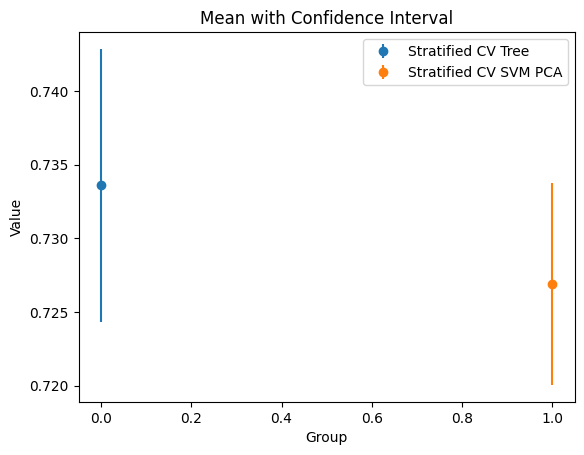

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Calculate mean and confidence interval on repeated accuracy_stratified_tree
mean_value = np.mean(accuracy_stratified_tree)
confidence_interval = stats.t.interval(0.95, len(accuracy_stratified_tree)-1, loc=np.mean(accuracy_stratified_tree), scale=stats.sem(accuracy_stratified_tree))

# Plot the mean and confidence interval
plt.errorbar(0, mean_value, yerr=(confidence_interval[1] - confidence_interval[0])/2, fmt='o', label='Stratified CV Tree')

# Calculate mean and confidence interval on accuracy_stratified_pca
mean_value = np.mean(accuracy_stratified_pca)
confidence_interval = stats.t.interval(0.95, len(accuracy_stratified_pca)-1, loc=np.mean(accuracy_stratified_pca), scale=stats.sem(accuracy_stratified_pca))

# Plot the mean and confidence interval
plt.errorbar(1, mean_value, yerr=(confidence_interval[1] - confidence_interval[0])/2, fmt='o', label='Stratified CV SVM PCA')


# Add labels and title
plt.xlabel('Group')
plt.ylabel('Value')
plt.title('Mean with Confidence Interval')

# Show the plot
plt.legend()
plt.show()


In [ ]:
print(f'Tempo di cross validation DecisionTree no PCA: {cv_time_decisiontree:.3f} secondi')

print(f'Tempo di cross validation SVM no PCA: {cv_time_svm:.3f} secondi')
print(f'Tempo di cross validation SVM con PCA: {cv_time_svm_pca:.3f} secondi')

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcola le probabilità predette per la classe positiva
y_pred_prob_tree = tree.predict_proba(X_test_tree)[:, 1]
y_pred_prob_svm_pca = svm_pca.predict_proba(X_test_svm_pca)[:,-1]

# utilizzando clf_pruned.predict(X_test), si ottengono solo le predizioni di classe effettive, che non forniscono le informazioni necessarie per costruire la curva ROC e calcolare l'AUC.

# Calcola la curva ROC e l'AUC della SVM senza PCA
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test_tree, y_pred_prob_tree)
auc_tree = roc_auc_score(y_test_tree, y_pred_prob_tree)

# Calcola la curva ROC e l'AUC della SVM con PCA
fpr_svm_pca, tpr_svm_pca, thresholds_svm_pca = roc_curve(y_test_svm_pca, y_pred_prob_svm_pca)
auc_svm_pca = roc_auc_score(y_test_svm_pca, y_pred_prob_svm_pca)

# Plotta la curva ROC dei due modelli per comparare le performance
plt.plot(fpr_tree, tpr_tree, label=f'Tree no PCA (AUC = {auc_tree:.2f})')
plt.plot(fpr_svm_pca, tpr_svm_pca, label=f'svm PCA (AUC = {auc_svm_pca:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()